# Baseline models
Several models were designed as baseline: 
- Copy-Paste: Copy the latest data
- Markovian: Use all of the data from the previous day
- Non-Markovian: Use all the data up to the decorrelation time

In [144]:
#import useful libraries
from IPython.display import Markdown, display
import importlib
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import warnings
from scipy import sparse
import matplotlib.colors as mcolors
stf_dir = os.path.join(os.pardir, 'spacetimeformer')
sys.path.append(stf_dir)
#from spacetimeformer import data
#importlib.reload(data) #to make sure the last version of stf is used

In [2]:
#load the dataset
data_path = "..\\Datasets\\Forecasting_aqua\\data_h_rolling_cst_int_v4.csv"
format = "%Y-%m-%d %H:%M:%S"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], format=format)
try:
    df.drop("sample",axis=1,inplace=True)
except:
    pass
df['Datetime']= time_df
#According to the work of Stefanie Merkly, these keys were more important than the others to predict chorophill a
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
#add some usefull variables at the end of the table
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#drop the first datapoints the first months are only meteorological data
first_point = (~df['diatom'].isnull()).idxmax()
dfs = df.drop(index=range(first_point))
df = dfs.set_index('Datetime')

In [3]:
def score(y_true,y_pred,epsilon=1e-16):
    
    MAEn = 1-np.nanmean(np.abs(y_true-y_pred))/np.nanmean(np.abs(y_true-np.nanmean(y_true,axis=0))+epsilon)
    R2_cat = 1-(np.nanmean(np.square(y_true-y_pred),axis=0)/
                np.nanmean(np.square(y_true-np.nanmean(y_true,axis=0)),axis=0)+epsilon)
    #note: the aggregation of R2 is quite tricky, as the two variables have highly different variances
    # the chosen method was to simply take the mean of the R2 coefficients of each variables
    R2 = np.nanmean(R2_cat)
    return {'R2':R2,'MAEn':MAEn,'R2_cat':R2_cat}

In [91]:
def kfold(model,input_tv,n_fold,input_test,target_tv,target_test):
    breakpoints = np.linspace(0,len(input_tv),n_fold+1,dtype=int)
    res = []
    for fold in range(n_fold):
        print(f"                                                 Fitting fold n°{fold}        ",end='\r')
        input_v = input_tv[breakpoints[fold]:breakpoints[fold+1]]
        y_v  = target_tv[breakpoints[fold]:breakpoints[fold+1]]
        input_t = pd.concat([input_tv[:breakpoints[fold]],input_tv[breakpoints[fold+1]:]])
        y_tr = pd.concat([target_tv[:breakpoints[fold]],target_tv[breakpoints[fold+1]:]])
        model.fit(input_t,y_tr,[breakpoints[fold],breakpoints[fold+1]])
        y_predtr = np.concatenate([model.pred(input_tv[:breakpoints[fold]]),
                                   model.pred(input_tv[breakpoints[fold+1]:])])
        
        y_predv = model.pred(input_v)
        y_predte = model.pred(input_test)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            s_train = score(y_tr.to_numpy(),y_predtr)
            s_val = score(y_v.to_numpy(),y_predv)
            s_test = score(target_test.to_numpy(),y_predte)
        res.append({'model':model,'fold':fold,'bp': breakpoints,'y_predtr':y_predtr, 'y_predv':y_predv,'y_predte':y_predte,
                    's_train':s_train,'s_val':s_val,'s_test':s_test,'outkeys':target_tv.keys()})
    return res

In [253]:
class CP_model:
    def __init__(self,target_keys:list):
        self.targets = target_keys
    def fit(self,inputs,targets,breakpoints):
        return
    def pred(self,inputs):
        return inputs[self.targets].to_numpy()
class Markov_lasso_model:
    def __init__(self,target_keys:list, allow_neg = True, **lasso_kwarg):
        from sklearn.linear_model import Lasso
        from sklearn.preprocessing import StandardScaler
        self.skmodel = Lasso(**lasso_kwarg)
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.target_keys = target_keys
        self.allow_neg = allow_neg
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        target = target.to_numpy()
        self._scalerout = self._scalerout.fit(target)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target)
        ntar = np.nan_to_num(ntar)
        self.skmodel.fit(ninp,ntar)
    def pred(self,inputs):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = self.skmodel.predict(ninp)
        if npred.ndim == 1:
            npred = np.expand_dims(npred,-1)
        if not self.allow_neg:
            scaled_back_pred = self._scalerout.inverse_transform(npred)
            return np.clip(scaled_back_pred, 0, np.max(scaled_back_pred))
        else:
            return self._scalerout.inverse_transform(npred)
class Markov_elast_model:
    def __init__(self,target_keys:list, allow_neg = True, **elast_kwarg):
        from sklearn.linear_model import ElasticNet
        from sklearn.preprocessing import StandardScaler
        self.skmodel = ElasticNet(**elast_kwarg)
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.target_keys = target_keys
        self.allow_neg = allow_neg
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        target = target.to_numpy()
        self._scalerout = self._scalerout.fit(target)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target)
        ntar = np.nan_to_num(ntar)
        self.skmodel.fit(ninp,ntar)
    def pred(self,inputs):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = self.skmodel.predict(ninp)
        if npred.ndim == 1:
            npred = np.expand_dims(npred,-1)
        if not self.allow_neg:
            scaled_back_pred = self._scalerout.inverse_transform(npred)
            return np.clip(scaled_back_pred, 0, np.max(scaled_back_pred))
        else:
            return self._scalerout.inverse_transform(npred)
class Markov_model:
    def __init__(self,target_keys:list, allow_neg=True):
        from sklearn.linear_model import LinearRegression
        from sklearn.preprocessing import StandardScaler
        self.skmodel = LinearRegression()
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.allow_neg = allow_neg
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        self._scalerout = self._scalerout.fit(target.values)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target.values)
        ntar = np.nan_to_num(ntar)
        self.skmodel.fit(ninp,ntar)
    def pred(self,inputs):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = self.skmodel.predict(ninp)
        if not self.allow_neg:
            scaled_back_pred = self._scalerout.inverse_transform(npred)
            return np.clip(scaled_back_pred, 0, np.max(scaled_back_pred))
        else:
            return self._scalerout.inverse_transform(npred)    

class NONMarkov_model:
    def __init__(self,target_keys:list, allow_neg=True,cor_th = 0.2,
                 max_lag = 30*24,decimate = 1):
        from sklearn.linear_model import LinearRegression
        from sklearn.preprocessing import StandardScaler
        #get the decorrelation time
        self.skmodel = [LinearRegression() for dim in range(len(target_keys))]
        self.target_keys = target_keys
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.cor_th = cor_th
        self.max_lag = max_lag
        self.decimate = decimate
        self.cor_masks = [np.array([]) for i in range(len(target_keys))]
        self.keep_in = [np.array([]) for i in range(len(target_keys))]
        self.allow_neg = allow_neg
    def fit(self,inputs,targets,breakpoints):
        
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        ####### Normalize
        #fill the validation fold with 0:
        self._scalerin = self._scalerin.fit(inputs.values)
        self._scalerout = self._scalerout.fit(targets.values)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(targets.values)
        ntar = np.nan_to_num(ntar)
        #process each out key separatly:
        ninp_pad = np.concatenate([ninp[:breakpoints[0]],
                                   np.zeros((breakpoints[1]-breakpoints[0],ninp.shape[1])),
                                   ninp[breakpoints[0]:]])
        ntar_pad = np.concatenate([ntar[:breakpoints[0]],
                                   np.zeros((breakpoints[1]-breakpoints[0],ntar.shape[1])),
                                   ntar[breakpoints[0]:]])
        
        for target in range(ntar.shape[1]):
            
            
            #### Find the decorrelation time
            
            cor = signal.correlate(ninp_pad,np.expand_dims(ntar_pad[:,target],-1), mode='full')/len(ntar)
            #note: due to the empty space left by the validation set, the correlation cannot reach one
            cor_lag = signal.correlation_lags(ninp_pad.shape[0],ntar_pad.shape[0], mode='full')
            idx0 = np.where(cor_lag==0)[0][0]
            idxmax = np.where(cor_lag == -self.max_lag)[0][0]
            cor_past = cor[idxmax:idx0]
            cor_mask = np.abs(cor_past)>self.cor_th
            #check if the mask can actually be smaller than the maximum length
            longest_lag = np.argmax(np.any(cor_mask,axis=1))
            cor_mask = cor_mask[longest_lag:,:]
            
            #check if some inputs are useless
            keep_in = np.any(cor_mask,axis=0)
            self.keep_in[target] = keep_in
            cor_mask = cor_mask[:,keep_in]
            self.cor_masks[target]=cor_mask
            
            ##### Format the input 
            
            
            #format the input
            start_inp = np.concatenate([np.arange(0,breakpoints[0]-cor_mask.shape[0]),
                                        np.arange(breakpoints[0],ninp.shape[0]-cor_mask.shape[0])])
            inp_nonmarkov = np.zeros((len(start_inp)//self.decimate+1,cor_mask.shape[0]*cor_mask.shape[1]))
            tar_nonmarkov = np.zeros(len(start_inp)//self.decimate+1)
            for idx,start in enumerate(start_inp[::self.decimate]):
                inp_nonmarkov[idx,:] = (cor_mask * ninp[start:start+cor_mask.shape[0],keep_in]).flatten()
                tar_nonmarkov[idx] = ntar[start+cor_mask.shape[0],target]
                
            #in case no variables are able to reach the correlation threshold, no training needed
            if cor_mask.shape[1]!=0:
                
                ########fit the model:
                print(f"inputs formated {target+1}/{ntar.shape[1]}; shape of input: {cor_mask.shape}",end='\r')

                self.skmodel[target].fit(inp_nonmarkov,tar_nonmarkov)
                print(f"model trained {target+1}/{ntar.shape[1]}  ",end = '\r')

                #### set all unused parameters to 0 for safety
                self.skmodel[target].coef_ *= cor_mask.flatten()
            
    def pred(self,inputs):
       
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        pred_nonmarkov = np.empty((len(inputs),len(self.target_keys)))
        pred_nonmarkov[:] = np.nan
                                  
        #format:
        for target in range(len(self.target_keys)):
            cor_mask = self.cor_masks[target]
            if cor_mask.shape[1]!=0:
                keep_in = self.keep_in[target]
                #format the input
                start_inp = np.arange(0,len(ninp)-cor_mask.shape[0])
                inp_nonmarkov = np.zeros((len(start_inp),cor_mask.shape[0]*cor_mask.shape[1]))

                for idx,start in enumerate(start_inp):
                    inp_nonmarkov[idx,:] = (cor_mask * ninp[start:start+cor_mask.shape[0],keep_in]).flatten()
                pred_nonmarkov[-len(start_inp):,target] = self.skmodel[target].predict(inp_nonmarkov)
        if not self.allow_neg:
            scaled_back_pred = self._scalerout.inverse_transform(pred_nonmarkov)
            return np.clip(scaled_back_pred, 0, np.max(scaled_back_pred))
        else:
            return self._scalerout.inverse_transform(pred_nonmarkov)
class Adaboost_model:
    def __init__(self,target_keys:list, allow_neg = True, **ada_kwarg):
        from sklearn.ensemble import AdaBoostRegressor
        from sklearn.preprocessing import StandardScaler
        self.skmodel = [AdaBoostRegressor(**ada_kwarg) for _ in target_keys]
        self._scalerin = StandardScaler()
        self._scalerout = StandardScaler()
        self.target_keys = target_keys
        self.allow_neg = allow_neg
    def fit(self,inputs,target,breakpoints):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        self._scalerin = self._scalerin.fit(inputs.values)
        target = target.to_numpy()
        self._scalerout = self._scalerout.fit(target)
        ninp = self._scalerin.transform(inputs.values)
        #fill nans with 0s
        ninp = np.nan_to_num(ninp)
        ntar = self._scalerout.transform(target)
        ntar = np.nan_to_num(ntar)
        for target in range(ntar.shape[1]):
            self.skmodel[target].fit(ninp,ntar[:,target])
    def pred(self,inputs):
        inputs = inputs.drop(columns=['Datetime'],errors='ignore')
        if len(inputs)==0:
            return np.zeros((len(inputs),len(self.target_keys)))
        ninp = self._scalerin.transform(inputs.values)
        ninp = np.nan_to_num(ninp)
        npred = np.empty((len(inputs),len(self.target_keys)))
        npred[:] = np.nan
        for target in range(len(self.skmodel)):
            npred[:,target] = self.skmodel[target].predict(ninp)
        if npred.ndim == 1:
            npred = np.expand_dims(npred,-1)
        if not self.allow_neg:
            scaled_back_pred = self._scalerout.inverse_transform(npred)
            return np.clip(scaled_back_pred, 0, np.max(scaled_back_pred))
        else:
            return self._scalerout.inverse_transform(npred)

# Sandbox run:

In [254]:
test_prop = 0.15
n_fold = 20
lag = 15
"""in_keys = ['Datetime','mean_chla_depth','aphanizomenon','nauplius','ciliate','cv_chla',
            'Ammonium','Nitrat','schmidt_stability','windspeed_max_GR',
            'thermocline','epi_temp','oxycline_depth',
            'mixed_layer_depth','mean_global_radiation'
            ]"""
concentration_keys = ['mean_o2_depth', 'mean_o2ppm_depth','mean_chla_depth','Nitrat', 'Nitrit',
                      'Ammonium', 'oP', 'TP', 'TN','asplanchna', 'asterionella', 'brachionus', 'diatom_chain', 'dinobryon', 'dirt', 'eudiaptomus',
                      'kellikottia', 'keratella_quadrata', 'maybe_cyano', 'nauplius', 'polyarthra', 'rotifers', 'synchaeta', 'unknown',
                      'unknown_plankton', 'ceratium', 'cyclops', 'fragilaria', 'keratella_cochlearis', 'paradileptus', 'bosmina',
                      'copepod_skins', 'daphnia', 'trichocerca', 'conochilus', 'diaphanosoma', 'fish', 'uroglena', 'leptodora',
                      'daphnia_skins', 'hydra', 'chaoborus', 'aphanizomenon', 'cluster_1','cluster_2', 'cluster_3', 
                      'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'diatom', 'ciliate']
in_keys = df.keys()
out_keys = ['mean_chla_depth','aphanizomenon']
test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()
dftest = df[-test_len:].copy()
#dftest.loc[:,concentration_keys] = np.log(1+dftest[concentration_keys])
#dftv.loc[:,concentration_keys] = np.log(1+dftv[concentration_keys])

inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:]

inputs_test = dftest[in_keys][:-24*lag]
targets_test = dftest[out_keys][24*lag:]

#note about decimation: the training time scales with 1/(decimate*decimate)
model = Adaboost_model(out_keys)

In [255]:
import time
t0 = time.perf_counter()
res = kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test)
t1 = time.perf_counter()
print(f"Time needed for the fold: {t1-t0}                           ")

Time needed for the fold: 522.947992100002                                


### Visualization functions

In [256]:
def nice_plot(targets_tv,res,targets_test=None,title='',scale='linear'):
    
    fig,axs = plt.subplots(len(targets_tv.keys()),figsize = (15,6*len(targets_tv.keys())))
    if len(targets_tv.keys())==1:
        axs=[axs]
    for idx,(ax,key) in enumerate(zip(axs,targets_tv.keys())):
        
        val_concat = np.concatenate([f['y_predv'] for f in res])
        
        artists = [ax.scatter(targets_tv.index,targets_tv[key].to_numpy(),s=1,c='k')]
        labels = ['True data']
        ax.set_title(f'{title} {key} (global R2={global_r2(res,targets_tv)[key]:.2f})')
        for fold in range(len(res[0]['bp'])-1):
            artists.append(ax.scatter(targets_tv.index[res[0]['bp'][fold]:res[0]['bp'][fold+1]],
                              res[fold]['y_predv'][:,idx],s=0.5))
            labels.append(f"Validation of fold {fold} (R2={res[fold]['s_val']['R2_cat'][idx]:.2f}))")
        if scale == 'linear':
            ax.set_ylabel("Concentration [ROI/s]")
        elif scale == 'log':
            ax.set_ylabel("Log concentration [log(c+1)]")
        ax.legend(artists,labels)
        if targets_test is not None:
            #the test predictions are not used for now
            #plot the mean and std of the test predictions
            #remove empty slice warning occuring when only nans are provided.
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)

                testres = np.array([resi['y_predte'] for resi in res])
                test_mean = np.nanmean(testres,axis=0)
                test_std = np.nanstd(testres,axis= 0)


            ax.scatter(targets_test.index,targets_test[key],c='k',s=1)
            ax.scatter(targets_test.index,test_mean[:,idx],s=0.5)
            ax.fill_between(targets_test.index,
                            test_mean[:,idx] - 1.96*test_std[:,idx],
                            test_mean[:,idx] + 1.96*test_std[:,idx],
                            color='gray', alpha=0.2)

def global_r2(res,true_data):
    global_pred = np.concatenate([f['y_predv'] for f in res])
    g_r2 = 1-(np.mean(np.square(true_data-global_pred),axis=0)/
                   np.mean(np.square(true_data-true_data.mean(axis=0)),axis=0))
    return g_r2
def printmd(string, color=None):
    
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
def plot_res(res,title='',true_data=None):
    for idx,key in enumerate(res[0]['outkeys']):
        '''
        print(title+
              f"R2 {key}:  {np.nanmean([f['s_val']['R2_cat'][idx] for f in res]):.2f}"+
              f" +/- {2*np.nanstd([f['s_val']['R2_cat'][idx] for f in res]):.2f}"+
              ' '*30)
        #replace the title with spaces for the other lines
        title = ' '*len(title)
              '''
        gr2 = global_r2(res,true_data)[key]
        r = max(-1,-min(0,gr2))*16
        g = max(0,gr2)*16
        b = 0
        code = '#'+str(hex(int(r)))[2]+str(hex(int(g)))[2]+str(hex(int(b)))[2]
        if true_data is not None:
            printmd(title+
                 f"Global R2 {key}: {gr2:.2f}",color=code)
        
    """print(' '*len(title)+
          f"R2 test: {np.nanmean([f['s_test']['R2'] for f in res]):.2f} +/- {2*np.nanstd([f['s_test']['R2'] for f in res]):.2f}"+
          ' '*30)
    """

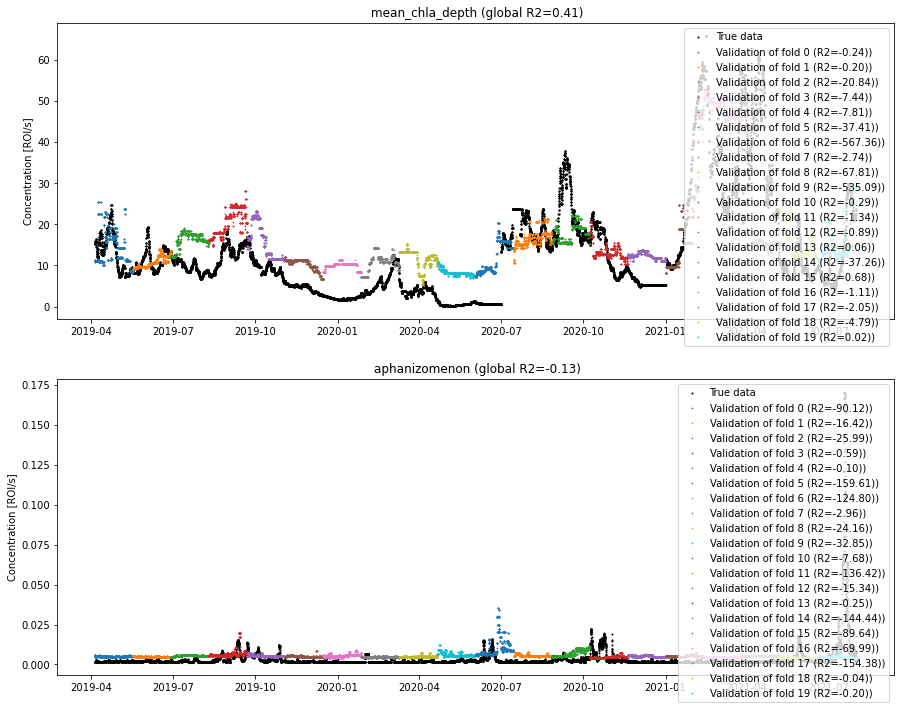

In [257]:
nice_plot(targets_tv,res)

In [276]:
[print(res_fold['s_train']) for res_fold in res]

{'R2': 0.8529763854546886, 'MAEn': 0.5508961119667308, 'R2_cat': array([0.86024145, 0.84571132])}
{'R2': 0.8310159686377514, 'MAEn': 0.5083427739300759, 'R2_cat': array([0.83083668, 0.83119526])}
{'R2': 0.8493950545757771, 'MAEn': 0.5500144706737078, 'R2_cat': array([0.85625998, 0.84253012])}
{'R2': 0.8467457929181686, 'MAEn': 0.5638723296562376, 'R2_cat': array([0.86065303, 0.83283856])}
{'R2': 0.8509084370708587, 'MAEn': 0.5446702532846392, 'R2_cat': array([0.85503468, 0.84678219])}
{'R2': 0.8451012860831213, 'MAEn': 0.5351940753468246, 'R2_cat': array([0.84887708, 0.84132549])}
{'R2': 0.8417082084972282, 'MAEn': 0.5221799892273619, 'R2_cat': array([0.84066105, 0.84275537])}
{'R2': 0.8584587741722736, 'MAEn': 0.5241520128320398, 'R2_cat': array([0.84192367, 0.87499388])}
{'R2': 0.8517045040127471, 'MAEn': 0.533113792229695, 'R2_cat': array([0.84690957, 0.85649943])}
{'R2': 0.8329217111779839, 'MAEn': 0.5200393659416385, 'R2_cat': array([0.84356853, 0.82227489])}
{'R2': 0.833877769589

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'alpha = 10/max, beta = 1')

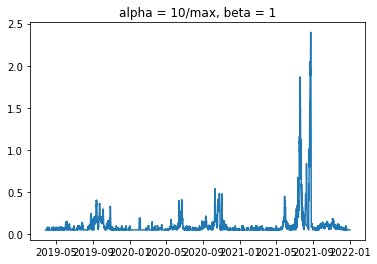

In [274]:
plt.plot(np.log(1+10*df['aphanizomenon']/df['aphanizomenon'].max()))
plt.title(f"alpha = 10/max, beta = 1")

In [258]:
plot_res(res,true_data=targets_tv)

<span style='color:#060'>Global R2 mean_chla_depth: 0.41</span>

<span style='color:#200'>Global R2 aphanizomenon: -0.13</span>

## Hyper parameter tuning

In [163]:
#dataset parameters
in_keys = df.keys()
out_keys = ['mean_chla_depth','aphanizomenon']
test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()
dftest = df[-test_len:].copy()
lag = 1
#
n_fold = 3


inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:]

inputs_test = dftest[in_keys][:-24*lag]
targets_test = dftest[out_keys][24*lag:]

for alpha in [0.01,0.05,0.1,0.5,1]:
    for l1_ratio in [0.1,0.3,0.5,0.7,0.9]:
        model = Markov_elast_model(out_keys,alpha=alpha,l1_ratio = l1_ratio,max_iter=5000)
        res = kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test)
        plot_res(res,title = f"alpha = {alpha}  l1= {l1_ratio} ",true_data =targets_tv)

<span style='color:#0e0'>alpha = 0.01  l1= 0.1 Global R2 mean_chla_depth: 0.89</span>

<span style='color:#200'>alpha = 0.01  l1= 0.1 Global R2 aphanizomenon: -2.24</span>

<span style='color:#0e0'>alpha = 0.01  l1= 0.3 Global R2 mean_chla_depth: 0.91</span>

<span style='color:#100'>alpha = 0.01  l1= 0.3 Global R2 aphanizomenon: -1.97</span>

<span style='color:#0e0'>alpha = 0.01  l1= 0.5 Global R2 mean_chla_depth: 0.92</span>

<span style='color:#100'>alpha = 0.01  l1= 0.5 Global R2 aphanizomenon: -1.79</span>

<span style='color:#0e0'>alpha = 0.01  l1= 0.7 Global R2 mean_chla_depth: 0.93</span>

<span style='color:#100'>alpha = 0.01  l1= 0.7 Global R2 aphanizomenon: -1.61</span>

<span style='color:#0e0'>alpha = 0.01  l1= 0.9 Global R2 mean_chla_depth: 0.93</span>

<span style='color:#100'>alpha = 0.01  l1= 0.9 Global R2 aphanizomenon: -1.40</span>

<span style='color:#0d0'>alpha = 0.05  l1= 0.1 Global R2 mean_chla_depth: 0.86</span>

<span style='color:#f00'>alpha = 0.05  l1= 0.1 Global R2 aphanizomenon: -0.97</span>

<span style='color:#0e0'>alpha = 0.05  l1= 0.3 Global R2 mean_chla_depth: 0.91</span>

<span style='color:#a00'>alpha = 0.05  l1= 0.3 Global R2 aphanizomenon: -0.63</span>

<span style='color:#0e0'>alpha = 0.05  l1= 0.5 Global R2 mean_chla_depth: 0.92</span>

<span style='color:#600'>alpha = 0.05  l1= 0.5 Global R2 aphanizomenon: -0.38</span>

<span style='color:#0e0'>alpha = 0.05  l1= 0.7 Global R2 mean_chla_depth: 0.93</span>

<span style='color:#300'>alpha = 0.05  l1= 0.7 Global R2 aphanizomenon: -0.24</span>

<span style='color:#0e0'>alpha = 0.05  l1= 0.9 Global R2 mean_chla_depth: 0.94</span>

<span style='color:#200'>alpha = 0.05  l1= 0.9 Global R2 aphanizomenon: -0.16</span>

<span style='color:#0d0'>alpha = 0.1  l1= 0.1 Global R2 mean_chla_depth: 0.82</span>

<span style='color:#800'>alpha = 0.1  l1= 0.1 Global R2 aphanizomenon: -0.53</span>

<span style='color:#0e0'>alpha = 0.1  l1= 0.3 Global R2 mean_chla_depth: 0.89</span>

<span style='color:#300'>alpha = 0.1  l1= 0.3 Global R2 aphanizomenon: -0.22</span>

<span style='color:#0e0'>alpha = 0.1  l1= 0.5 Global R2 mean_chla_depth: 0.91</span>

<span style='color:#100'>alpha = 0.1  l1= 0.5 Global R2 aphanizomenon: -0.09</span>

<span style='color:#0e0'>alpha = 0.1  l1= 0.7 Global R2 mean_chla_depth: 0.92</span>

<span style='color:#000'>alpha = 0.1  l1= 0.7 Global R2 aphanizomenon: -0.01</span>

<span style='color:#0e0'>alpha = 0.1  l1= 0.9 Global R2 mean_chla_depth: 0.93</span>

<span style='color:#000'>alpha = 0.1  l1= 0.9 Global R2 aphanizomenon: 0.01</span>

<span style='color:#090'>alpha = 0.5  l1= 0.1 Global R2 mean_chla_depth: 0.62</span>

<span style='color:#900'>alpha = 0.5  l1= 0.1 Global R2 aphanizomenon: -0.62</span>

<span style='color:#0b0'>alpha = 0.5  l1= 0.3 Global R2 mean_chla_depth: 0.71</span>

<span style='color:#010'>alpha = 0.5  l1= 0.3 Global R2 aphanizomenon: 0.09</span>

<span style='color:#0b0'>alpha = 0.5  l1= 0.5 Global R2 mean_chla_depth: 0.73</span>

<span style='color:#020'>alpha = 0.5  l1= 0.5 Global R2 aphanizomenon: 0.19</span>

<span style='color:#0b0'>alpha = 0.5  l1= 0.7 Global R2 mean_chla_depth: 0.71</span>

<span style='color:#030'>alpha = 0.5  l1= 0.7 Global R2 aphanizomenon: 0.23</span>

<span style='color:#0a0'>alpha = 0.5  l1= 0.9 Global R2 mean_chla_depth: 0.66</span>

<span style='color:#040'>alpha = 0.5  l1= 0.9 Global R2 aphanizomenon: 0.25</span>

<span style='color:#070'>alpha = 1  l1= 0.1 Global R2 mean_chla_depth: 0.47</span>

<span style='color:#b00'>alpha = 1  l1= 0.1 Global R2 aphanizomenon: -0.69</span>

<span style='color:#070'>alpha = 1  l1= 0.3 Global R2 mean_chla_depth: 0.48</span>

<span style='color:#030'>alpha = 1  l1= 0.3 Global R2 aphanizomenon: 0.19</span>

<span style='color:#060'>alpha = 1  l1= 0.5 Global R2 mean_chla_depth: 0.41</span>

<span style='color:#020'>alpha = 1  l1= 0.5 Global R2 aphanizomenon: 0.17</span>

<span style='color:#030'>alpha = 1  l1= 0.7 Global R2 mean_chla_depth: 0.22</span>

<span style='color:#000'>alpha = 1  l1= 0.7 Global R2 aphanizomenon: 0.05</span>

<span style='color:#100'>alpha = 1  l1= 0.9 Global R2 mean_chla_depth: -0.07</span>

<span style='color:#000'>alpha = 1  l1= 0.9 Global R2 aphanizomenon: -0.02</span>

## Explaination of k-fold
When running a k-fold cross-validation, the data is splitted into k different folds (below, k=3). The training of the model is then done k times, each time using a different fold of the data as validation while all of the others are used to train the model parameters

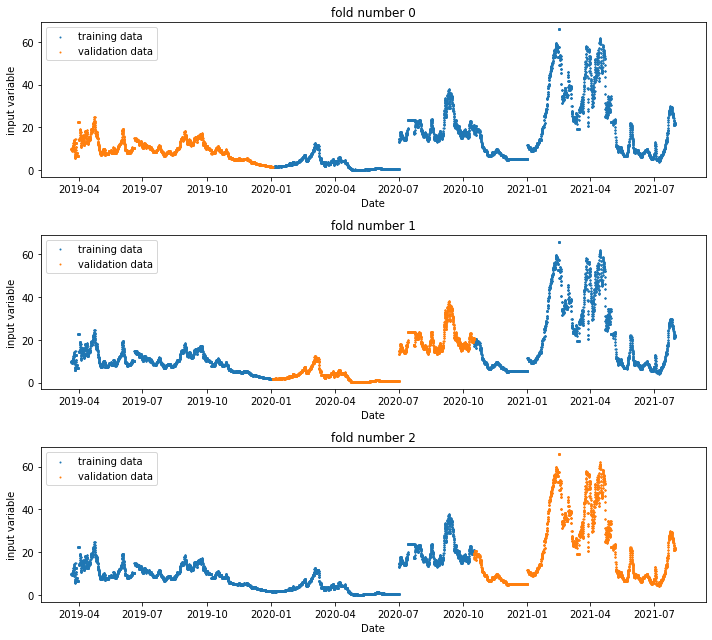

In [14]:
#number of folds
k = 3
#delay (in days)
lag = 1
#explanatory variables (only the chla is here for this example)
inputs_tv = dftv['mean_chla_depth'][:-24*lag]
# target variables to predict (only the chla is here for this example)
targets_tv = dftv['mean_chla_depth'][24*lag:].reset_index(drop=True)


breakpoints = np.linspace(0,len(inputs_tv),k+1,dtype=int)
fig,axs= plt.subplots(k,1,figsize=(10,k*3),tight_layout=True)
for idx,ax in enumerate(axs):
    ax.set_title(f"fold number {idx}")
    train =ax.scatter(dftv.index[breakpoints[idx+1]:breakpoints[-1]],
                      inputs_tv[breakpoints[idx+1]:breakpoints[-1]],s=1,c='tab:blue')
    train =ax.scatter(dftv.index[breakpoints[0]:breakpoints[idx]],
                      inputs_tv[breakpoints[0]:breakpoints[idx]],s=1,c='tab:blue')
    val = ax.scatter(dftv.index[breakpoints[idx]:breakpoints[idx+1]],
                     inputs_tv[breakpoints[idx]:breakpoints[idx+1]],s=1,c='tab:orange')
    ax.set_ylabel("input variable")
    ax.set_xlabel("Date")
    ax.legend([train,val],['training data','validation data'])

This validation method has the advantage to produce validation results on all the time series, but at the cost of using more time for training. 

Another drawback is that if the structure driving the system changes over time, then using it can cause some problems (see Cross-validation, limitation and misuse on Wikipedia). Moreover, using it on time series requires each fold to be decorrelated from the others: Imagine that we did a (length of time series) fold validation: each validation would then have a very close neighbor in the training set (on hour earlier and on hour later). This is why the data was not shuffled before the folds were made (as it is usually done)

### Goodness of fit
As the model is optimized to predict the training data, it will nearly always fit it extremely well. The validation data is here to detect over fitting: when the model is "too good" at predicting the training data and that it will not be able to be usable on anything it has never seen

In [16]:
#chose a lag
lag = 1

#explanatory variables
inputs_tv = dftv[:-24*lag]
# target variables to predict 
target_keys = ['mean_chla_depth','aphanizomenon']
targets_tv = dftv[24*lag:][target_keys]

#chose a model
model = Markov_lasso_model(target_keys,allow_neg=False,alpha = 0.05)

#run the kfold
n_fold = 5
res = kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test)
print("Model trained"+' '*70)

Model trained                                                                      


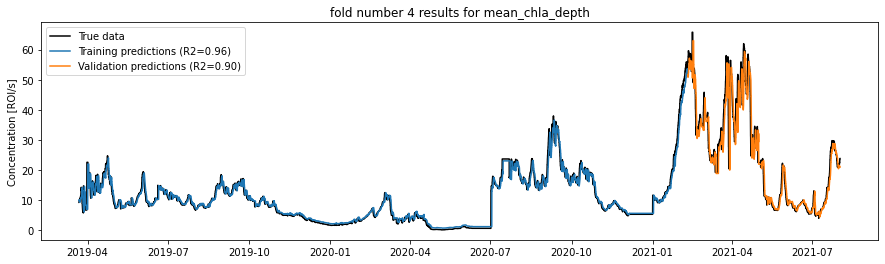

In [19]:
#lets only focus on a specific fold
fold_id  = 4
res_fold = res[fold_id]

#and lets only focus on a specific key
key_id  = 0

#plot the results##############
fig,ax = plt.subplots(1,figsize=(15,4))
true_data = targets_tv.iloc[:,key_id]
#plot the true data
true = ax.plot(true_data,c='k')

#plot the predicted training data
bp = res_fold['bp']
train = ax.plot(true_data.index[0:bp[fold_id]],res_fold['y_predtr'][0:bp[fold_id],key_id],c= 'tab:blue')
ax.plot(true_data.index[bp[fold_id+1]:],res_fold['y_predtr'][bp[fold_id]:,key_id],c='tab:blue')
#plot the validatation data
val = ax.plot(true_data.index[bp[fold_id]:bp[fold_id+1]],res_fold['y_predv'][:,key_id],c='tab:orange')

ax.legend([true[0],train[0],val[0]],
         ['True data',
          f'Training predictions (R2={res_fold["s_train"]["R2_cat"][key_id]:.2f})',
          f'Validation predictions (R2={res_fold["s_val"]["R2_cat"][key_id]:.2f})'
         ])
ax.set_ylabel("Concentration [ROI/s]")
ax.set_title(f"fold number {fold_id} results for {target_keys[key_id]}")
plt.show()

This shift between validation and training makes the training fit less interesting to plot, as its fit is not representative of the behavior of the model on unseen data. A better kind of plot is to plot only the validation of each fold: this way all of the true data is used as a validation on the plot

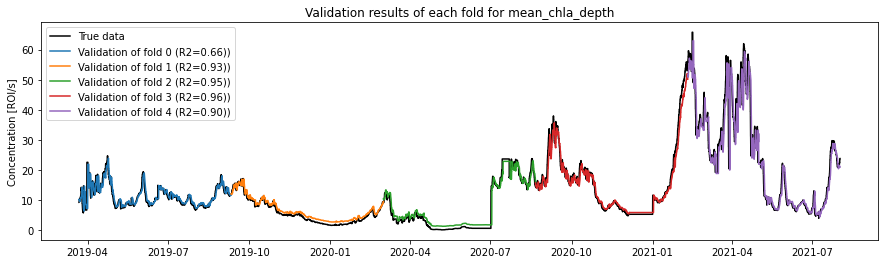

In [20]:
#lets still focus on a specific key
key_id  = 0

#plot the results##############
fig,ax = plt.subplots(1,figsize=(15,4))
true_data = targets_tv.iloc[:,key_id]
#plot the true data
true = ax.plot(true_data,c='k')

#plot the predicted validation data for each fold
artist_list = [true[0]]
label_list = ["True data"]
for fold_id,res_fold in enumerate(res):
    bp = res_fold['bp']
    #plot the validatation data
    artist_list.append(ax.plot(true_data.index[bp[fold_id]:bp[fold_id+1]],res_fold['y_predv'][:,key_id])[0])
    label_list.append(f"Validation of fold {fold_id} (R2={res_fold['s_val']['R2_cat'][key_id]:.2f}))")
ax.legend(artist_list,
          label_list)
ax.set_ylabel("Concentration [ROI/s]")
ax.set_title(f"Validation results of each fold for {target_keys[key_id]}")
plt.show()

This plotting method also allows to see if the $R^2$ score is consistent through the folds (in the case of aphanizomenon and a simple linear model, it is clearly not), a condition necessary to extrapolate to unseen data

In [21]:
plot_res(res)

R2 mean_chla_depth:  0.88 +/- 0.23                              
R2 aphanizomenon:  -4.48 +/- 20.25                              


In [22]:
model = Markov_lasso_model(out_keys,alpha=0.1,max_iter=5000,allow_neg=False)
n_fold = 20
res = kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test)

In [23]:
global_r2(res,targets_tv)

mean_chla_depth    0.934033
aphanizomenon      0.444480
dtype: float64

In [24]:
plot_res(res)

R2 mean_chla_depth:  0.26 +/- 2.94                              
R2 aphanizomenon:  -2.13 +/- 11.66                              


In [164]:
#setup a full comparaison of the different models:

### general parameters
test_prop = 0.15 #proportion of the data used for testing
n_fold = 10 #number of folds
lag = 1 #number of days to forecast in advance

## data grid (try both with the full dataset and one composed of selected variables)
# note that the variables were selected following the inputs of a limnologist and previous litterature

in_keys1 = df.keys()
in_keys2 =  ['mean_chla_depth','aphanizomenon','nauplius','ciliate','cv_chla',
            'Ammonium','Nitrat','schmidt_stability','windspeed_max_GR',
            'thermocline','epi_temp','oxycline_depth',
            'mixed_layer_depth','mean_global_radiation'
            ]
in_keys_list = [in_keys1,in_keys2]
data_names = ['large','small']
### outputs to predict
out_keys = ['mean_chla_depth','aphanizomenon']

### scaling to compare:

#keys that will be scaled down with log(1+amp*x/max(x))
concentration_keys = ['mean_o2_depth', 'mean_o2ppm_depth','mean_chla_depth','Nitrat', 'Nitrit',
                      'Ammonium', 'oP', 'TP', 'TN','asplanchna', 'asterionella', 'brachionus', 'diatom_chain', 'dinobryon', 'dirt', 'eudiaptomus',
                      'kellikottia', 'keratella_quadrata', 'maybe_cyano', 'nauplius', 'polyarthra', 'rotifers', 'synchaeta', 'unknown',
                      'unknown_plankton', 'ceratium', 'cyclops', 'fragilaria', 'keratella_cochlearis', 'paradileptus', 'bosmina',
                      'copepod_skins', 'daphnia', 'trichocerca', 'conochilus', 'diaphanosoma', 'fish', 'uroglena', 'leptodora',
                      'daphnia_skins', 'hydra', 'chaoborus', 'aphanizomenon', 'cluster_1','cluster_2', 'cluster_3', 
                      'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'diatom', 'ciliate']

scaling = ['linear','log']
amp = 10

### models to try:
models = []
models.append(CP_model(out_keys))
models.append(Markov_model(out_keys,allow_neg=False))
models.append(Markov_lasso_model(out_keys,alpha = 0.1,allow_neg = False))
models.append(NONMarkov_model(out_keys,cor_th = 0.3,max_lag = 24*5,decimate=1,allow_neg = False))
#models.append(NONMarkov_model(out_keys,cor_th = 0.2,max_lag = 24*15,decimate=1))
models_name = ['Copy-Paste','Markov','Lasso','Non-Markov small','Non-Markov large']

<span style='color:#0f0'>Copy-Paste, large dset, linear: Global R2 mean_chla_depth: 0.94</span>

<span style='color:#090'>Copy-Paste, large dset, linear: Global R2 aphanizomenon: 0.60</span>

<span style='color:#0f0'>Copy-Paste, large dset, log: Global R2 mean_chla_depth: 0.97</span>

<span style='color:#0b0'>Copy-Paste, large dset, log: Global R2 aphanizomenon: 0.74</span>

<span style='color:#0e0'>Markov, large dset, linear: Global R2 mean_chla_depth: 0.89</span>

<span style='color:#a00'>Markov, large dset, linear: Global R2 aphanizomenon: -0.68</span>

<span style='color:#0f0'>Markov, large dset, log: Global R2 mean_chla_depth: 0.95</span>

<span style='color:#070'>Markov, large dset, log: Global R2 aphanizomenon: 0.49</span>

<span style='color:#0e0'>Lasso, large dset, linear: Global R2 mean_chla_depth: 0.93</span>

<span style='color:#070'>Lasso, large dset, linear: Global R2 aphanizomenon: 0.44</span>

<span style='color:#0f0'>Lasso, large dset, log: Global R2 mean_chla_depth: 0.95</span>

<span style='color:#0b0'>Lasso, large dset, log: Global R2 aphanizomenon: 0.72</span>

<span style='color:#0e0'>Non-Markov small, large dset, linear: Global R2 mean_chla_depth: 0.94</span>

<span style='color:#b00'>Non-Markov small, large dset, linear: Global R2 aphanizomenon: -0.71</span>

<span style='color:#0f0'>Non-Markov small, large dset, log: Global R2 mean_chla_depth: 0.96</span>

<span style='color:#070'>Non-Markov small, large dset, log: Global R2 aphanizomenon: 0.44</span>

<span style='color:#0f0'>Copy-Paste, small dset, linear: Global R2 mean_chla_depth: 0.94</span>

<span style='color:#090'>Copy-Paste, small dset, linear: Global R2 aphanizomenon: 0.60</span>

<span style='color:#0f0'>Copy-Paste, small dset, log: Global R2 mean_chla_depth: 0.97</span>

<span style='color:#0b0'>Copy-Paste, small dset, log: Global R2 aphanizomenon: 0.74</span>

<span style='color:#0f0'>Markov, small dset, linear: Global R2 mean_chla_depth: 0.94</span>

<span style='color:#0a0'>Markov, small dset, linear: Global R2 aphanizomenon: 0.63</span>

<span style='color:#0f0'>Markov, small dset, log: Global R2 mean_chla_depth: 0.97</span>

<span style='color:#0b0'>Markov, small dset, log: Global R2 aphanizomenon: 0.73</span>

<span style='color:#0e0'>Lasso, small dset, linear: Global R2 mean_chla_depth: 0.93</span>

<span style='color:#0a0'>Lasso, small dset, linear: Global R2 aphanizomenon: 0.63</span>

<span style='color:#0f0'>Lasso, small dset, log: Global R2 mean_chla_depth: 0.95</span>

<span style='color:#0b0'>Lasso, small dset, log: Global R2 aphanizomenon: 0.73</span>

<span style='color:#0f0'>Non-Markov small, small dset, linear: Global R2 mean_chla_depth: 0.94</span>

<span style='color:#090'>Non-Markov small, small dset, linear: Global R2 aphanizomenon: 0.61</span>

<span style='color:#0f0'>Non-Markov small, small dset, log: Global R2 mean_chla_depth: 0.96</span>

<span style='color:#0b0'>Non-Markov small, small dset, log: Global R2 aphanizomenon: 0.71</span>

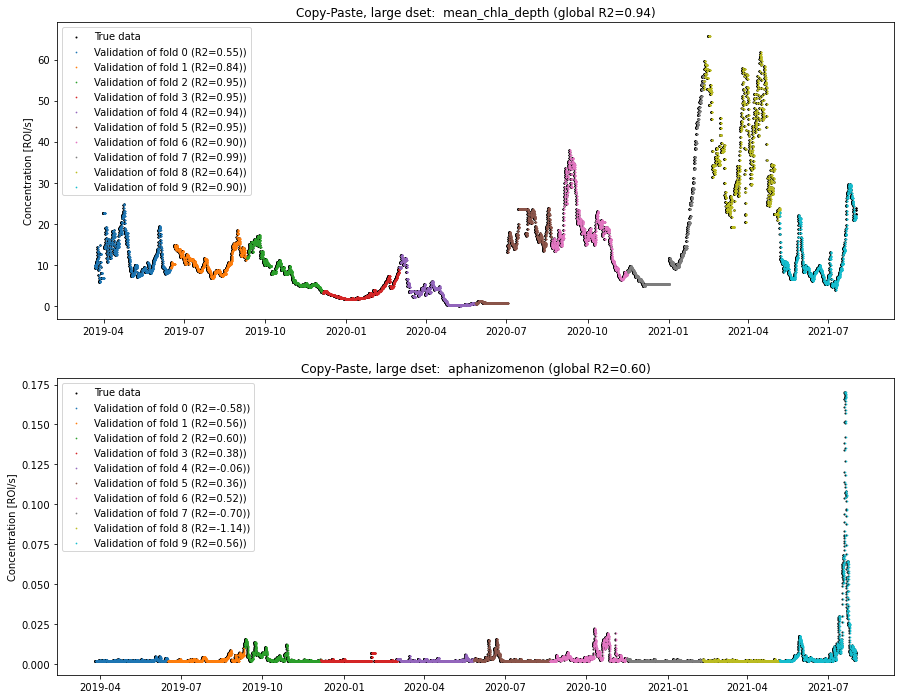

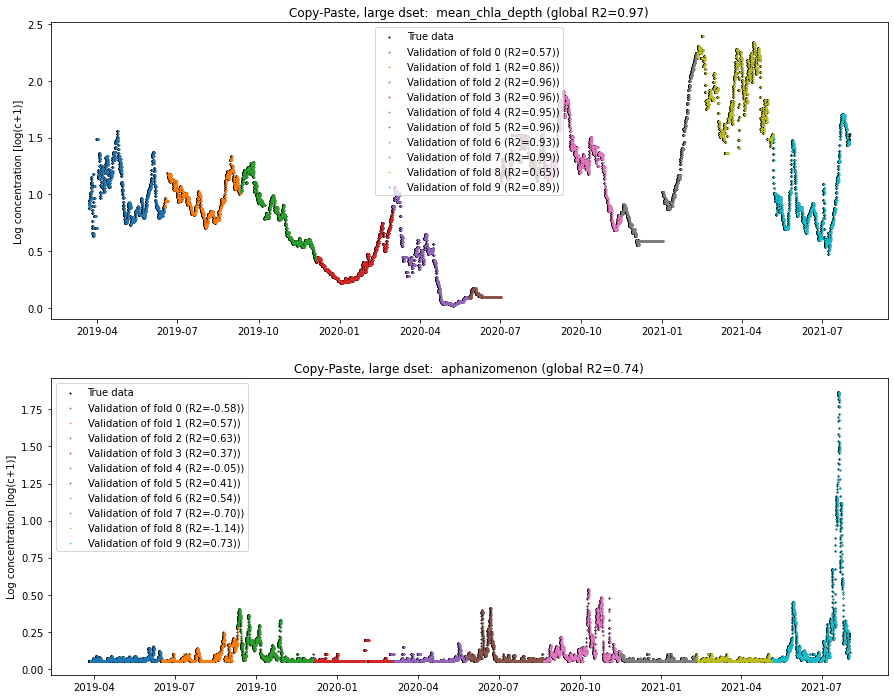

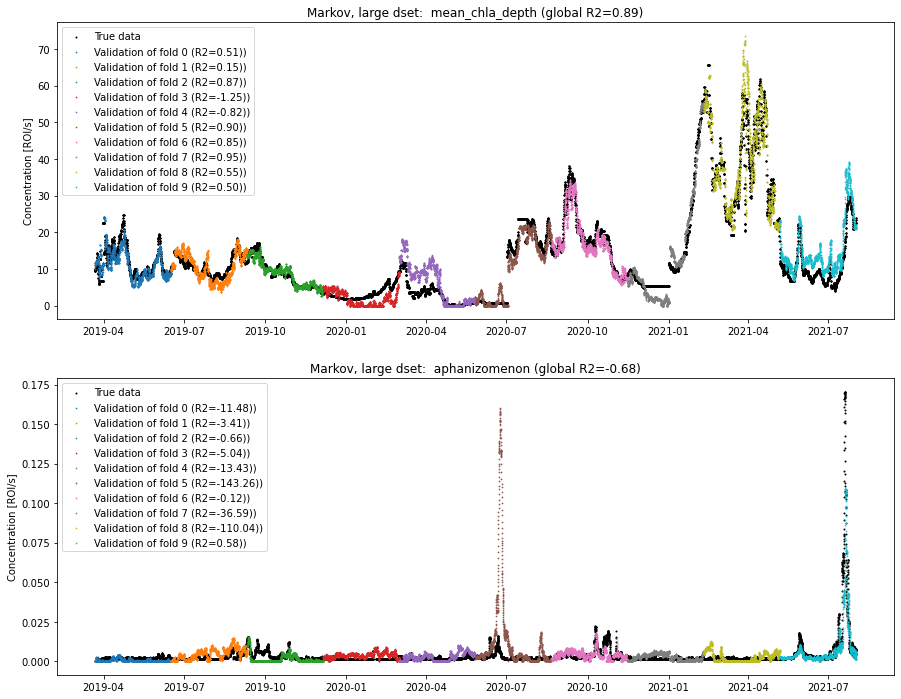

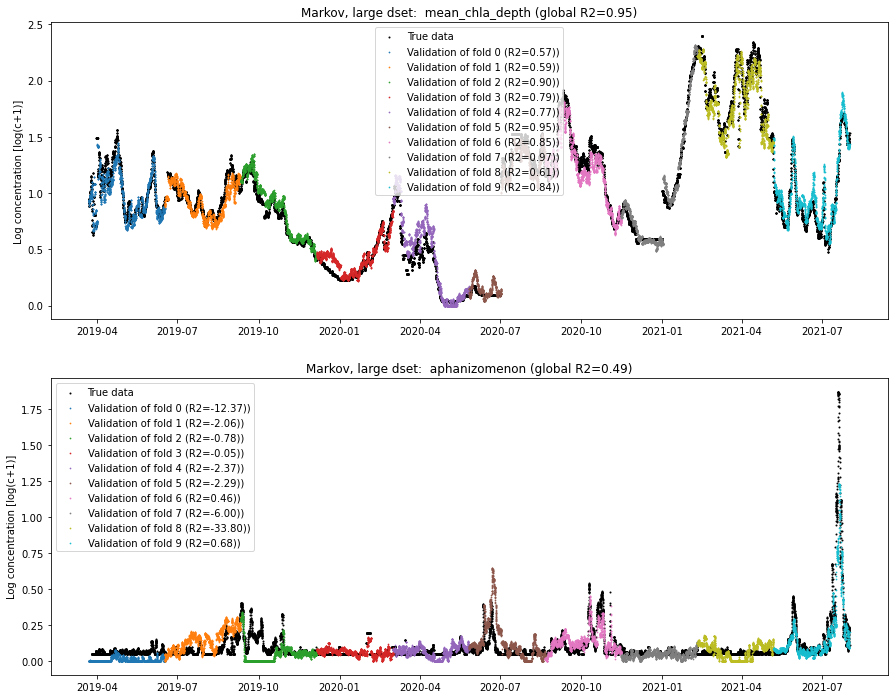

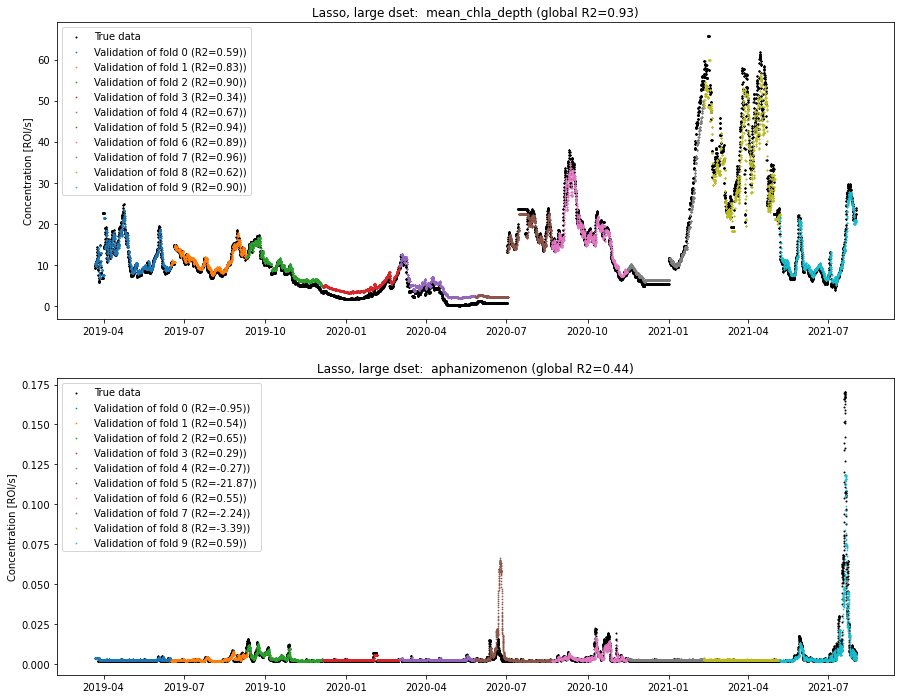

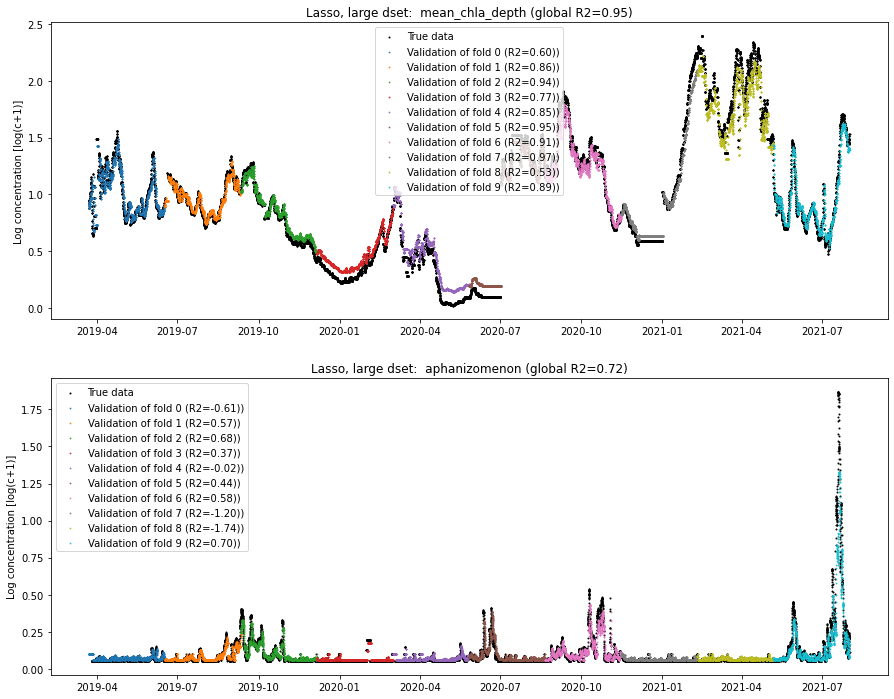

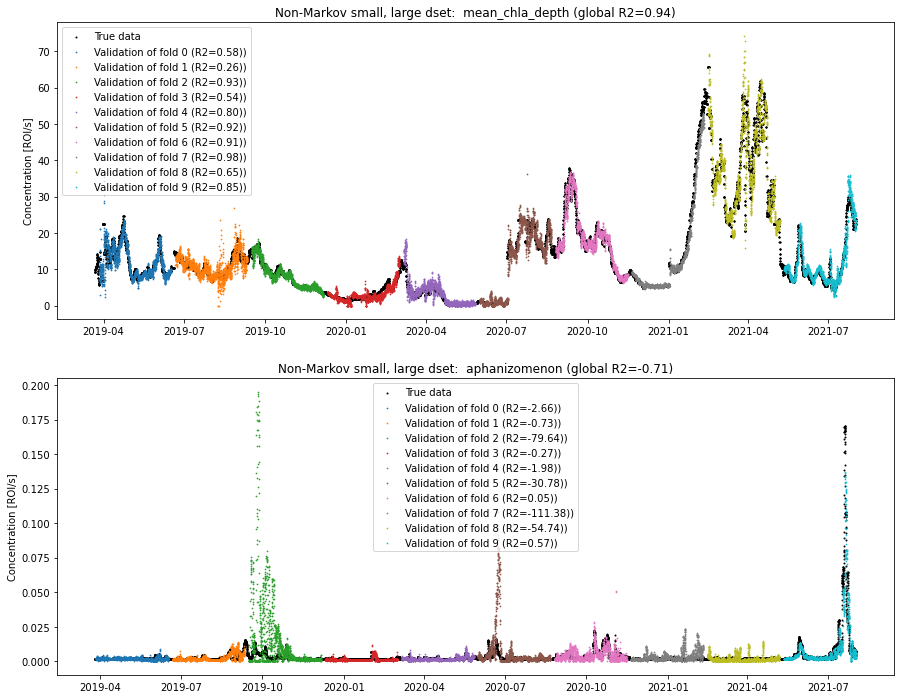

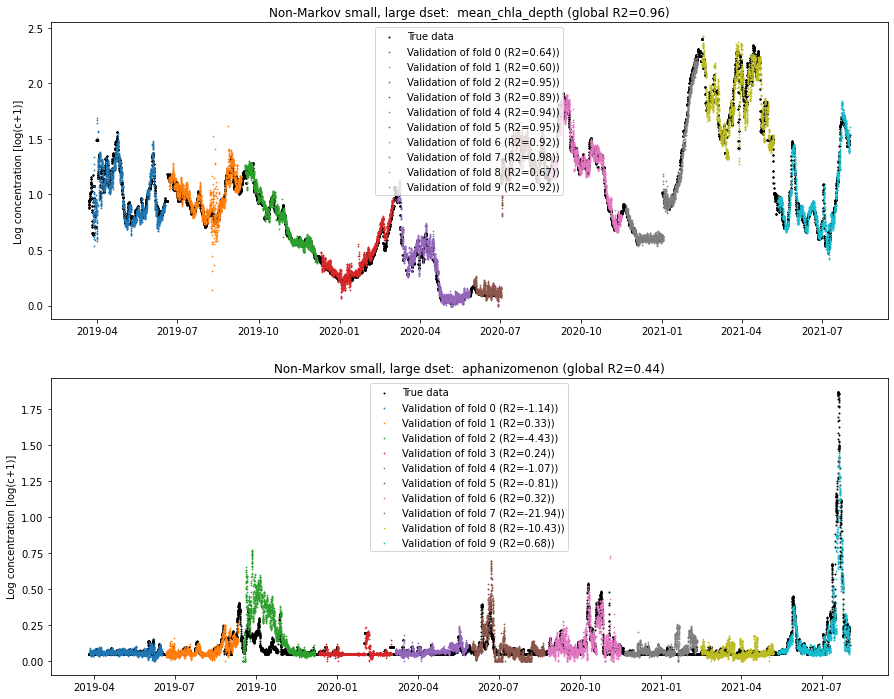

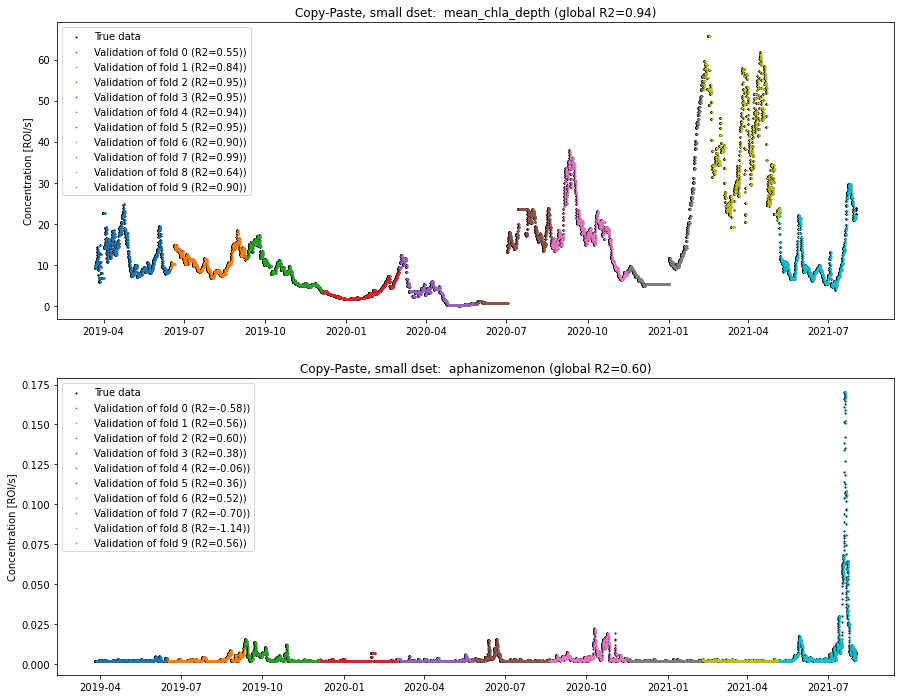

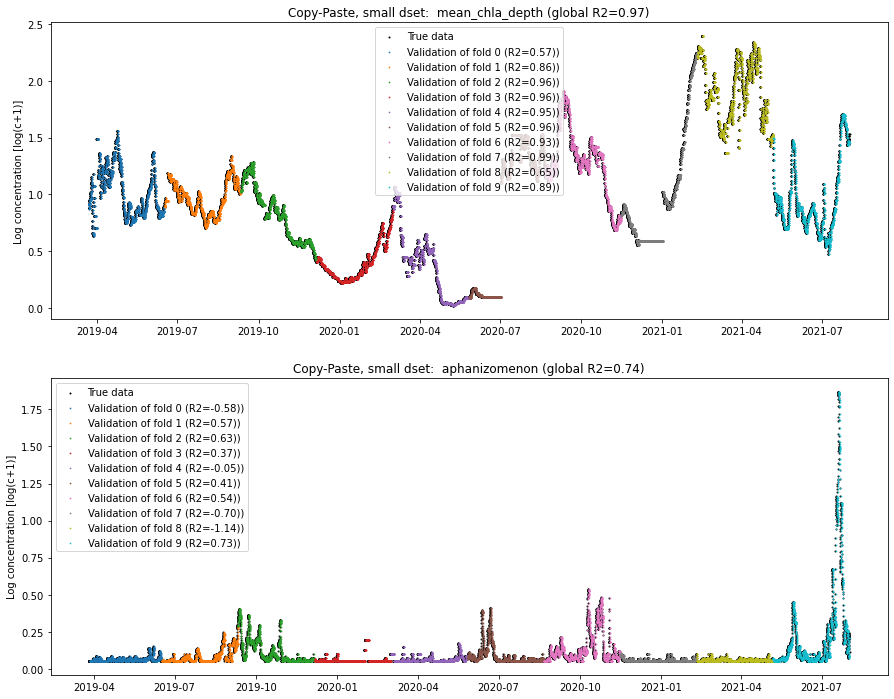

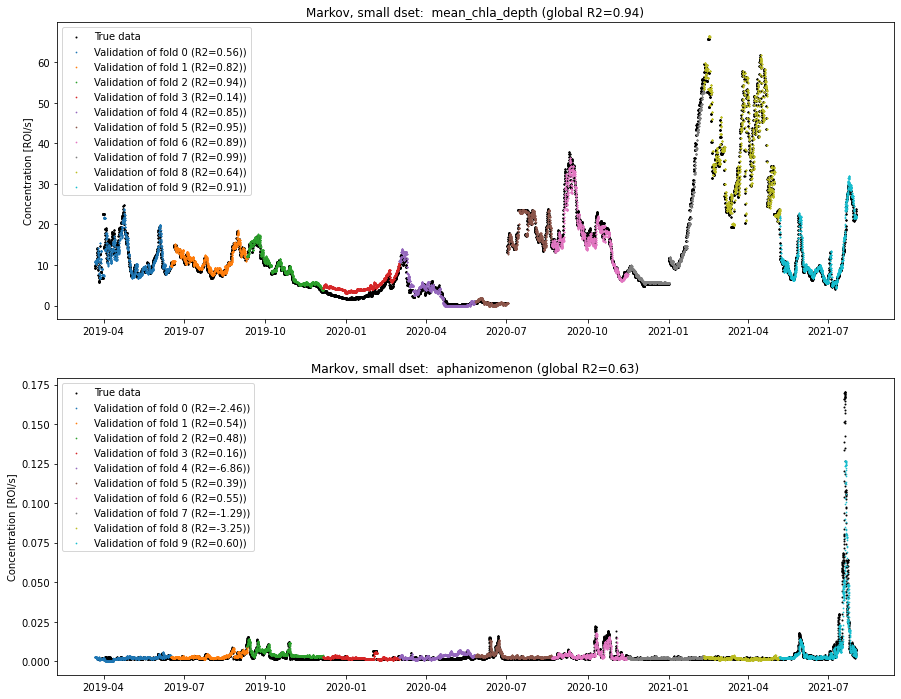

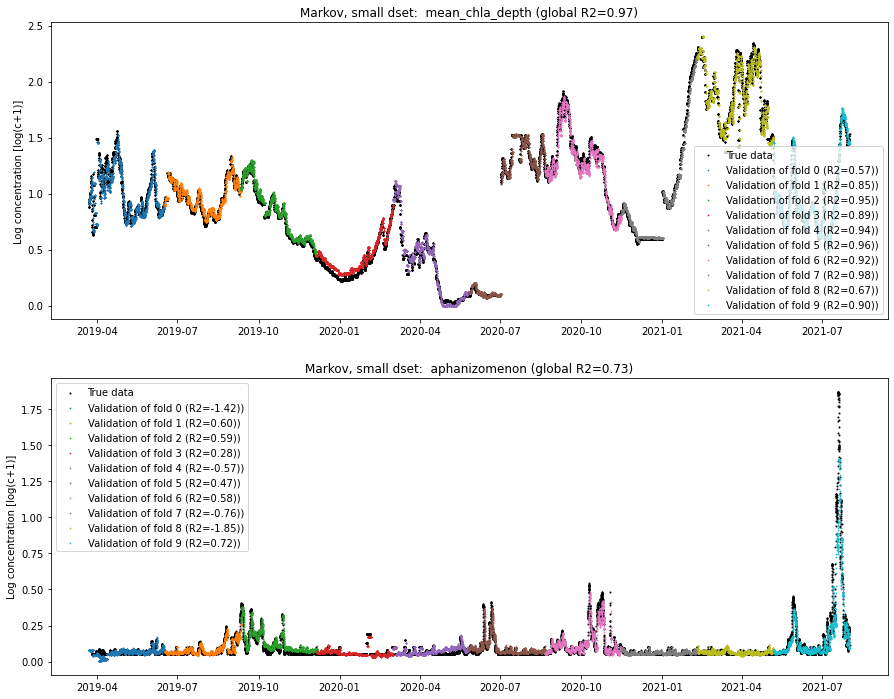

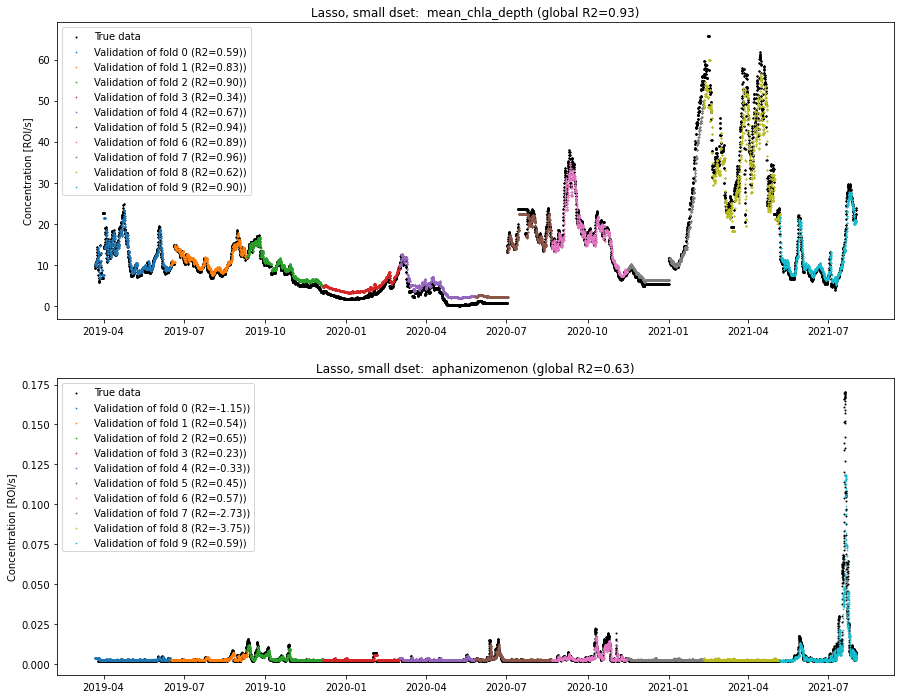

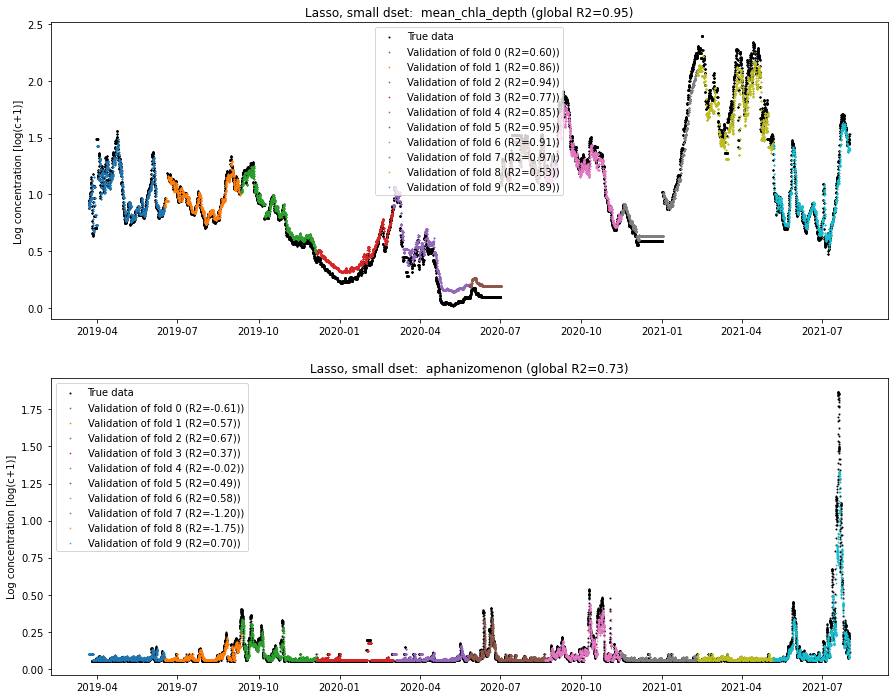

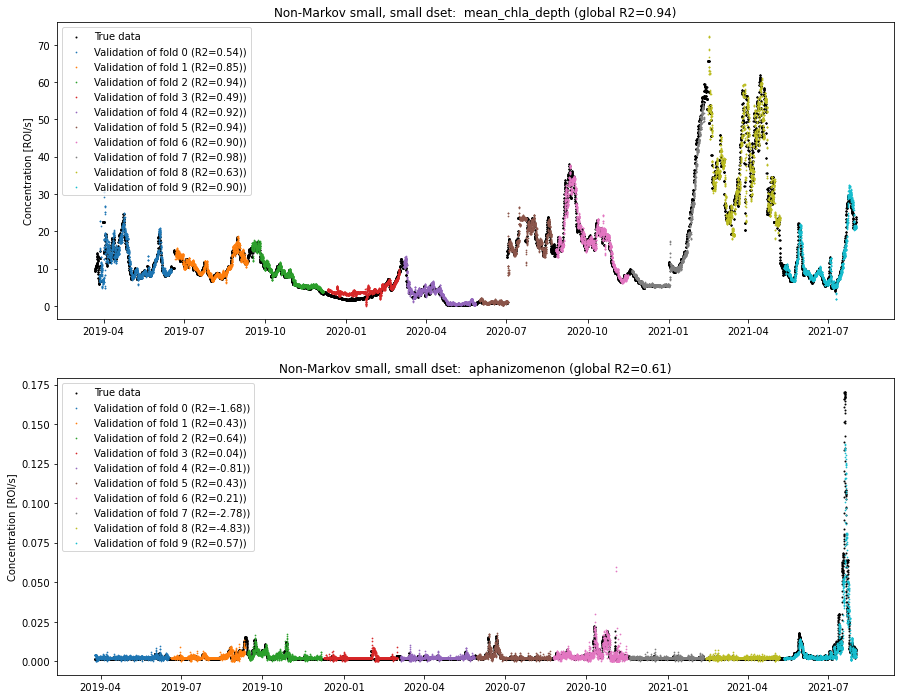

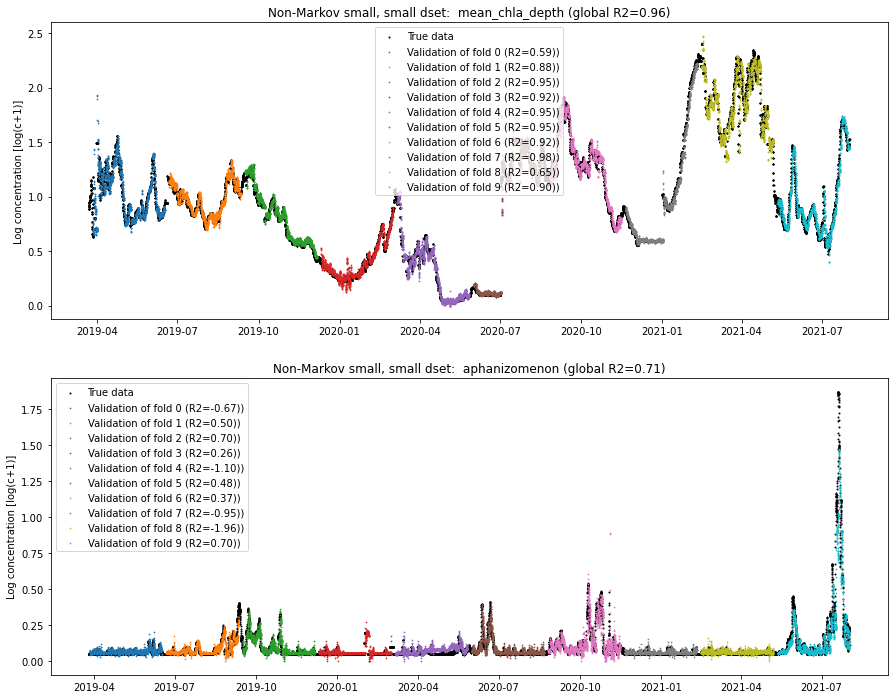

In [165]:
test_len = int(len(df)*test_prop)
dftest = df[-test_len:]
dftv = df[:-test_len]
dflog = df.copy()
dflog.loc[:,concentration_keys] = np.log(1+amp*df[concentration_keys]/df[concentration_keys].max())
dftest_log = dflog[-test_len:]
dftv_log = dflog[:-test_len]
for data,data_name in zip(in_keys_list,data_names):
    for model,name in zip(models,models_name):
        for scale in scaling:
            if scale == 'log':
                inputs_tv = dftv_log[data][:-24*lag]
                targets_tv = dftv_log[24*lag:][out_keys]
                inputs_test = dftest_log[data][:-24*lag]
                targets_test = dftest_log[out_keys][24*lag:]
            else:
                inputs_tv = dftv[data][:-24*lag]
                targets_tv = dftv[24*lag:][out_keys]
                inputs_test = dftest[data][:-24*lag]
                targets_test = dftest[out_keys][24*lag:]
            
                
            res = kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test)

            nice_plot(targets_tv,res,title = f"{name}, {data_name} dset: ",scale=scale)

            plot_res(res,true_data=targets_tv,title=f"{name}, {data_name} dset, {scale}: ")
            

### Important note about the results
Even if the copy-past results _look_ good on the plots, it is actually due to the close horizontal proximity, defined by the lag, where only the vertical proximity is meaningful. This plotting method is still used in published research, and those plots needs to be taken carefully

## Influence of the number of folds
In theory, an increased number of folds gives better results, as more data can be used during training. Below is an experiment validating this thought

In [62]:
n_folds = [2,3,4,6,8,10,16,20,25]
models = []
models.append(CP_model(out_keys))
models.append(Markov_model(out_keys,allow_neg=False))
models.append(Markov_lasso_model(out_keys,alpha = 0.1,allow_neg = False))
models.append(NONMarkov_model(out_keys,cor_th = 0.3,max_lag = 24*5,decimate=1,allow_neg = False))
models_name = ['Copy-Paste','Markov','Lasso','Non-Markov small']

#dataset parameters
in_keys = df.keys()
out_keys = ['mean_chla_depth','aphanizomenon']
test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()
dftest = df[-test_len:].copy()
lag = 5


inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:]

inputs_test = dftest[in_keys][:-24*lag]
targets_test = dftest[out_keys][24*lag:]

res_model = {}

for model,name in zip(models,models_name):
    res_model[name]=[]
    for n_fold in n_folds:
        print(100*' '+f"{name} {n_fold}",end='\r')
        res_model[name].append(kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test))

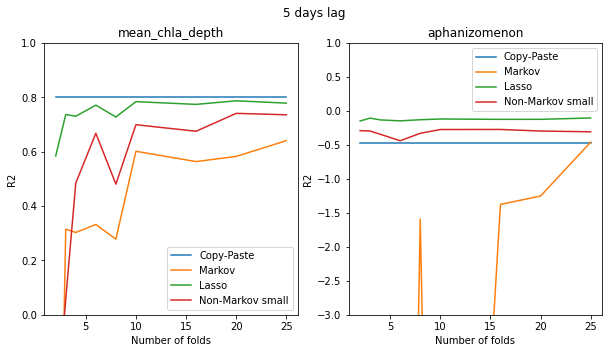

In [70]:
fig,axs = plt.subplots(1,len(out_keys),figsize=(10,5))
artists = np.empty((len(models_name),len(out_keys)),dtype=plt.Line2D)
labels = models_name
for idx_name, name in enumerate(models_name):
    res_fold = res_model[name]
    gr2_list = [global_r2(res,targets_tv) for res in res_fold]
    for idx_key,(key, ax) in enumerate(zip(out_keys, axs)):
        artists[idx_name,idx_key] = ax.plot(n_folds,[el[key] for el in gr2_list])[0]
        ax.set_title(f"{key}")
for idx_ax, ax in enumerate(axs):
    ax.legend(artists[:,idx_ax],labels)
    ax.set_ylabel("R2")
    ax.set_xlabel("Number of folds")
axs[0].set_ylim(0,1)
axs[1].set_ylim(-3,1)
fig.suptitle("5 days lag")
plt.show()

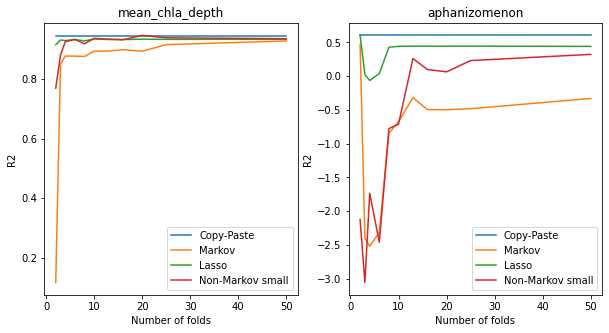

In [59]:
fig,axs = plt.subplots(1,len(out_keys),figsize=(10,5))
artists = np.empty((len(models_name),len(out_keys)),dtype=plt.Line2D)
labels = models_name
for idx_name, name in enumerate(models_name):
    res_fold = res_model[name]
    gr2_list = [global_r2(res,targets_tv) for res in res_fold]
    for idx_key,(key, ax) in enumerate(zip(out_keys, axs)):
        artists[idx_name,idx_key] = ax.plot(n_folds,[el[key] for el in gr2_list])[0]
        ax.set_title(f"{key}")
for idx_ax, ax in enumerate(axs):
    ax.legend(artists[:,idx_ax],labels)
    ax.set_ylabel("R2")
    ax.set_xlabel("Number of folds")

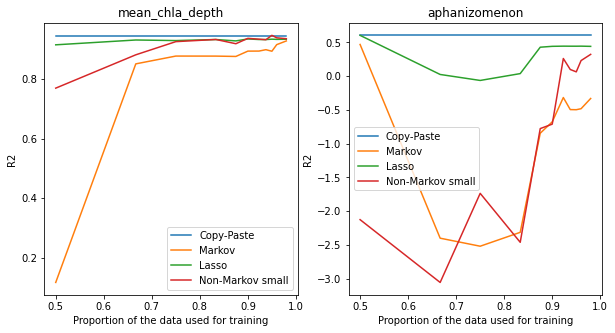

In [61]:
fig,axs = plt.subplots(1,len(out_keys),figsize=(10,5))
artists = np.empty((len(models_name),len(out_keys)),dtype=plt.Line2D)
labels = models_name
n_folds = np.array(n_folds)
for idx_name, name in enumerate(models_name):
    res_fold = res_model[name]
    gr2_list = [global_r2(res,targets_tv) for res in res_fold]
    for idx_key,(key, ax) in enumerate(zip(out_keys, axs)):
        artists[idx_name,idx_key] = ax.plot((n_folds-1)/n_folds,[el[key] for el in gr2_list])[0]
        ax.set_title(f"{key}")
for idx_ax, ax in enumerate(axs):
    ax.legend(artists[:,idx_ax],labels)
    ax.set_ylabel("R2")
    ax.set_xlabel("Proportion of the data used for training")

These $R^2$ vs folds plots show three things: 
- The more folds, the better the results
- The more folds, the more stable the results
- The models do not all need the same amount of data: the copy-past is constant, whereas the Markov model that does not use any regularization improve continuously with the amount of training data

## Fit of the models with increased lag

In [36]:
#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()

#output keys 
out_keys= ['mean_chla_depth','aphanizomenon']
#chose a model
#model = Markov_lasso_model(out_keys,alpha=0.05,allow_neg=False)
model = CP_model(out_keys)
#chose the number of folds
n_fold = 25
res_lag = []
tar_lag = []
for lag in lags:
    print(' '*100+f"lag {lag}/{lags[-1]}",end= '\r')
    inputs_tv = dftv[in_keys][:-24*lag]
    targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)

    inputs_test = dftest[in_keys][:-24*lag]
    targets_test = dftest[out_keys][24*lag:].reset_index(drop=True)
    res_lag.append(kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test))
    tar_lag.append(targets_tv)

In [337]:
def R2_vs_lag(lags,res_model:list,tar_data:list,title="R2 vs lags",model_names = None):
    keys = res_model[0][0][0]['outkeys']
    fig,axs = plt.subplots(1,len(keys),figsize=(len(keys)*5,4))
    artists = np.empty((len(res_model),len(keys)),dtype=plt.Line2D)
    if len(tar_data)==1:
        tar_data = tar_data * len(res_model)
    for idx_model,(res_lag,tar_lag) in enumerate(zip(res_model,tar_data)):
        gr2_lag = []
        for res,tar in zip(res_lag,tar_lag):
            gr2_lag.append(global_r2(res,tar))
        gr2_lag = np.array(gr2_lag)
        fig.suptitle(title)
        for idx,(ax,key) in enumerate(zip(axs,keys)):
            artists[idx_model,idx] = ax.plot(lags,gr2_lag[:,idx])[0]
            ax.hlines(0,min(lags),max(lags),color='k',linestyle='dashed')
            ax.set_title(key)
            ax.set_xlabel("lag [day]")
            ax.set_ylabel("R2")
            ax.set_ylim(max(-0.1,np.min(gr2_lag[:,idx])-0.1),1)
    if model_names is not None:
        [ax.legend(artists[:,idx],model_names) for idx,ax in enumerate(axs)]
    plt.show()

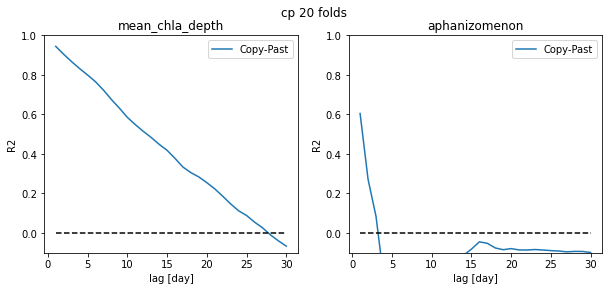

In [81]:
R2_vs_lag(lags,[res_lag],[tar_lag],title='cp 20 folds',model_names = ['Copy-Past'])

In [168]:
#plot the r2 vs lag graph for each model
models = []
models.append(CP_model(out_keys))
models.append(Markov_model(out_keys,allow_neg=False))
models.append(Markov_lasso_model(out_keys,alpha = 0.1,allow_neg = False))
models.append(NONMarkov_model(out_keys,cor_th = 0.3,max_lag = 24*5,decimate=1,allow_neg = False))
models_name = ['Copy-Paste','Markov','Lasso','Non-Markov small']

#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#input keys
in_keys = dftv.keys()
#output keys 
out_keys= ['mean_chla_depth','aphanizomenon']
#chose the number of folds
n_fold = 25
#chose some preprocessing:
'''
#linear:
dftv = df[:-test_len]
dftest = df[-test_len:]
'''
#log:
dftv = dflog[:-test_len]
dftest = dflog[-test_len:]

res_model = []
for model in models:
    res_lag = []
    tar_lag = []
    for lag in lags:
        print(' '*100+f"lag {lag}/{lags[-1]}",end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)

        inputs_test = dftest[in_keys][:-24*lag]
        targets_test = dftest[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test))
        tar_lag.append(targets_tv)
    res_model.append(res_lag)

In [327]:
#plot the r2 vs lag graph for each data preprocessing

#lags to fit a model to
maxlag = 30
lags = np.arange(1,maxlag+1)

#datas:

expert_keys = ['mean_chla_depth','aphanizomenon','nauplius','ciliate','cv_chla',
            'Ammonium','Nitrat','schmidt_stability','windspeed_max_GR',
            'thermocline','epi_temp','oxycline_depth',
            'mixed_layer_depth','mean_global_radiation'
            ]
datas = []

datas.append({'in_keys':df.keys(),'dftv':df[:-test_len],'dftest':df[-test_len:]})
datas.append({'in_keys':expert_keys,'dftv':df[:-test_len],'dftest':df[-test_len:]})
datas.append({'in_keys':df.keys(),'dftv':dflog[:-test_len],'dftest':dflog[-test_len:]})
datas.append({'in_keys':expert_keys,'dftv':dflog[:-test_len],'dftest':dflog[-test_len:]})
data_names = ['full linear','small linear','full log','small log']
#output keys 
out_keys= ['mean_chla_depth','aphanizomenon']
#chose the number of folds
n_fold = 20
#chose the model
model = Markov_lasso_model(out_keys,allow_neg=False,alpha = 0.05)
res_data = []
tar_data = []
for data in datas:
    res_lag = []
    tar_lag = []
    in_keys = data['in_keys']
    dftv = data['dftv']
    dftest = data['dftest']
    
    for lag in lags:
        print(' '*100+f"lag {lag}/{lags[-1]}",end= '\r')
        inputs_tv = dftv[in_keys][:-24*lag]
        targets_tv = dftv[out_keys][24*lag:].reset_index(drop=True)

        inputs_test = dftest[in_keys][:-24*lag]
        targets_test = dftest[out_keys][24*lag:].reset_index(drop=True)
        res_lag.append(kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test))
        tar_lag.append(targets_tv)
    res_data.append(res_lag)
    tar_data.append(tar_lag)

In [336]:
len(tar_data)

4

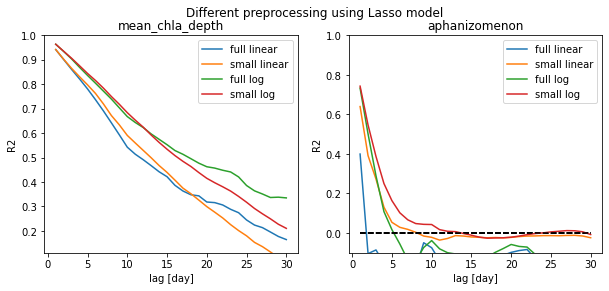

In [338]:
R2_vs_lag(lags,res_data[:],tar_data,model_names = data_names[:],title = "Different preprocessing using Lasso model")

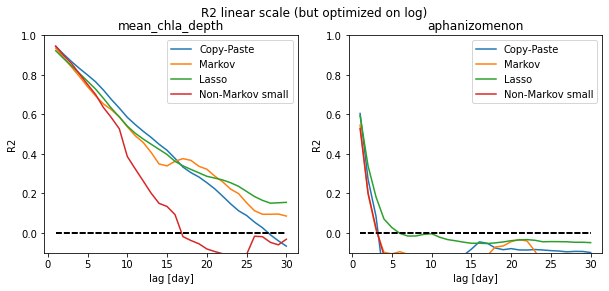

In [307]:
title = "R2 linear scale (but optimized on log)"
model_names = models_name[:]
keys = res_model[0][0][0]['outkeys']
fig,axs = plt.subplots(1,len(keys),figsize=(len(keys)*5,4))
artists = np.empty((len(res_model),len(keys)),dtype=plt.Line2D)
for idx_model,res_lag in enumerate(res_model):
    gr2_lag = []
    for res,tar in zip(res_lag,tar_lag):
        global_pred = np.concatenate([f['y_predv'] for f in res])
        global_pred_sb= (np.exp(global_pred)-1)/amp *df[keys].max().to_numpy()
        true_data_sb= (np.exp(tar)-1)/amp *df[keys].max().to_numpy()
        g_r2 = 1-(np.mean(np.square(true_data_sb-global_pred_sb),axis=0)/
                   np.mean(np.square(true_data_sb-np.mean(true_data_sb,axis=0)),axis=0))
        gr2_lag.append(g_r2)
    gr2_lag = np.array(gr2_lag)
    fig.suptitle(title)
    for idx,(ax,key) in enumerate(zip(axs,keys)):
        artists[idx_model,idx] = ax.plot(lags,gr2_lag[:,idx])[0]
        ax.hlines(0,min(lags),max(lags),color='k',linestyle='dashed')
        ax.set_title(key)
        ax.set_xlabel("lag [day]")
        ax.set_ylabel("R2")
        ax.set_ylim(max(-0.1,np.min(gr2_lag[:,idx])-0.1),1)
if model_names is not None:
    [ax.legend(artists[:,idx],model_names) for idx,ax in enumerate(axs)]
plt.show()

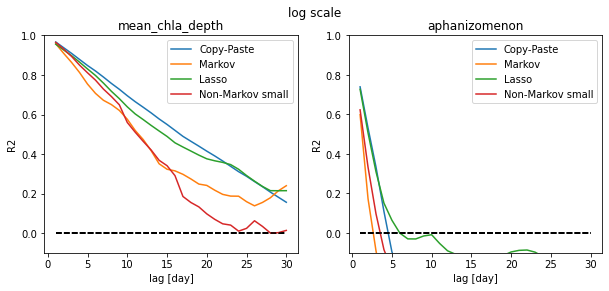

In [170]:
R2_vs_lag(lags,res_model[:],[tar_lag],model_names = models_name[:],title = "log scale")

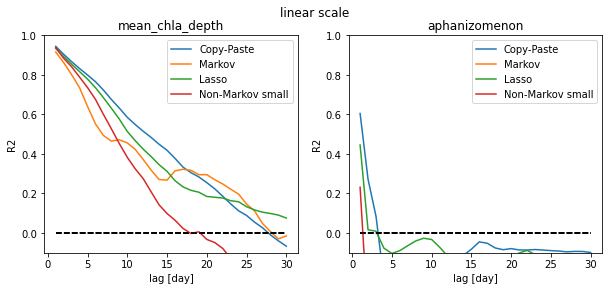

In [167]:
R2_vs_lag(lags,res_model[:],[tar_lag],model_names = models_name[:],title = "linear scale")

## Log scale
To reduce the amplitude of the huge blooms, the concentration levels can be normalized and log transformed

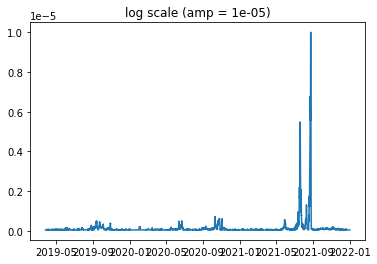

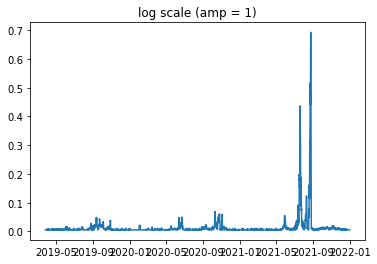

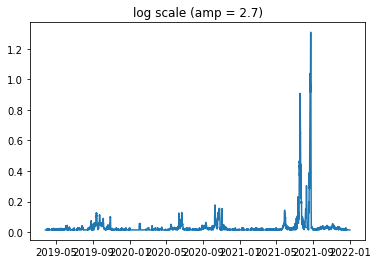

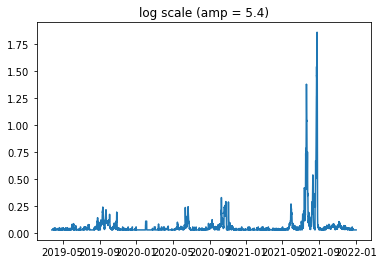

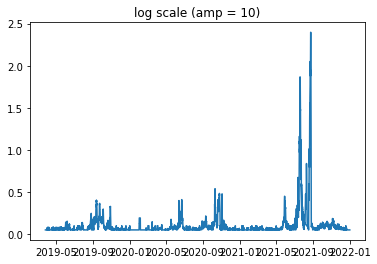

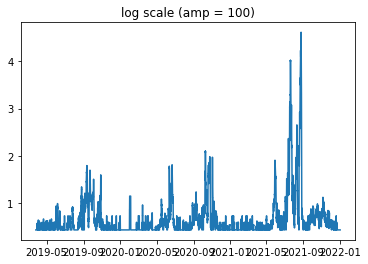

In [119]:
concentration_keys = ['mean_o2_depth', 'mean_o2ppm_depth','mean_chla_depth','Nitrat', 'Nitrit',
                      'Ammonium', 'oP', 'TP', 'TN','asplanchna', 'asterionella', 'brachionus', 'diatom_chain', 'dinobryon', 'dirt', 'eudiaptomus',
                      'kellikottia', 'keratella_quadrata', 'maybe_cyano', 'nauplius', 'polyarthra', 'rotifers', 'synchaeta', 'unknown',
                      'unknown_plankton', 'ceratium', 'cyclops', 'fragilaria', 'keratella_cochlearis', 'paradileptus', 'bosmina',
                      'copepod_skins', 'daphnia', 'trichocerca', 'conochilus', 'diaphanosoma', 'fish', 'uroglena', 'leptodora',
                      'daphnia_skins', 'hydra', 'chaoborus', 'aphanizomenon', 'cluster_1','cluster_2', 'cluster_3', 
                      'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'diatom', 'ciliate']
df_log = df.copy()
for amp in [0.00001,1,2.7,5.4,10,100]:
    df_log.loc[:,concentration_keys] = np.log(1+amp*df[concentration_keys]/df[concentration_keys].max())
    plt.plot(df_log['aphanizomenon'])
    plt.title(f"log scale (amp = {amp})")
    plt.show()

### Lasso inspection
It might be useful to compare the non-zero coefficients of the lasso-model and to compare them with the important keys selected based on previous work:

In [230]:
#train a lasso for a specific lag:
test_prop = 0.15
n_fold = 20
lag = 15
in_keys = ['mean_chla_depth','aphanizomenon','nauplius','ciliate','cv_chla',
            'Ammonium','Nitrat','schmidt_stability','windspeed_max_GR',
            'thermocline','epi_temp','oxycline_depth',
            'mixed_layer_depth','mean_global_radiation'
            ]
"""
concentration_keys = ['mean_o2_depth', 'mean_o2ppm_depth','mean_chla_depth','Nitrat', 'Nitrit',
                      'Ammonium', 'oP', 'TP', 'TN','asplanchna', 'asterionella', 'brachionus', 'diatom_chain', 'dinobryon', 'dirt', 'eudiaptomus',
                      'kellikottia', 'keratella_quadrata', 'maybe_cyano', 'nauplius', 'polyarthra', 'rotifers', 'synchaeta', 'unknown',
                      'unknown_plankton', 'ceratium', 'cyclops', 'fragilaria', 'keratella_cochlearis', 'paradileptus', 'bosmina',
                      'copepod_skins', 'daphnia', 'trichocerca', 'conochilus', 'diaphanosoma', 'fish', 'uroglena', 'leptodora',
                      'daphnia_skins', 'hydra', 'chaoborus', 'aphanizomenon', 'cluster_1','cluster_2', 'cluster_3', 
                      'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'diatom', 'ciliate']"""
#in_keys = df.keys()
out_keys = ['mean_chla_depth','aphanizomenon']
test_len = int(len(df)*test_prop)
dftv = df[:-test_len].copy()
dftest = df[-test_len:].copy()
#dftest.loc[:,concentration_keys] = np.log(1+dftest[concentration_keys])
#dftv.loc[:,concentration_keys] = np.log(1+dftv[concentration_keys])

inputs_tv = dftv[in_keys][:-24*lag]
targets_tv = dftv[out_keys][24*lag:]

inputs_test = dftest[in_keys][:-24*lag]
targets_test = dftest[out_keys][24*lag:]

#note about decimation: the training time scales with 1/(decimate*decimate)
model = Markov_lasso_model(out_keys,alpha=0.1)


In [231]:
res = kfold(model,inputs_tv,n_fold,inputs_test,targets_tv,targets_test)

In [232]:
coeffs = np.array([res_fold['model'].skmodel.coef_ for res_fold in res])
coeffs_map = coeffs!= 0

In [233]:
for idx_out, out_key in enumerate(out_keys):
    print(f"Usefull keys for {out_key}:")
    for idx_in,in_key in enumerate(in_keys):
        if coeffs_map[:,idx_out,idx_in].any():
            print(f"     {in_key}: {int(100*np.sum(coeffs_map[:,idx_out,idx_in])/n_fold)}%")
        

Usefull keys for mean_chla_depth:
     mean_chla_depth: 100%
     nauplius: 100%
     Ammonium: 100%
     windspeed_max_GR: 100%
     mixed_layer_depth: 100%
Usefull keys for aphanizomenon:
     aphanizomenon: 100%
     nauplius: 100%
     epi_temp: 100%
     oxycline_depth: 100%


In [216]:
for idx_out, out_key in enumerate(out_keys):
    print(f"Usefull keys for {out_key}:")
    for idx_in,in_key in enumerate(in_keys):
        if coeffs_map[:,idx_out,idx_in].any():
            print(f"     {in_key}: {int(100*np.sum(coeffs_map[:,idx_out,idx_in])/n_fold)}%")
        

Usefull keys for mean_chla_depth:
     mean_chla_depth: 100%
Usefull keys for aphanizomenon:
     oxycline_depth: 100%
     diatom_chain: 100%
     ceratium: 100%
     cyclops: 100%
     aphanizomenon: 100%
     cluster_4: 100%
     cluster_5: 100%
